In [3]:
from download_day import download_day
from load_saved_fd4 import load_saved_fd4
from scrape_aircraft_list import scrape_aircraft_list
from get_perf_model_typecodes import get_perf_model_typecodes 
from match_icao_model import match_icao_model
from process_airport_list import process_airport_list
from generate_flightpath import generate_flightpath
from plot_flightpaths import plot_flightpaths
from get_engine_data import get_engine_data
from perf_model_powerplant_parser import perf_model_powerplant_parser
from match_engine_to_emissions_db import match_engine_to_emissions_db
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import sleep
from geopy import distance
from icet import icet
from bffm2 import bffm2
%matplotlib inline

In [ ]:
# User Inputs:
start_time_str       = '2024-01-01T00:00:00Z'
stop_time_str        = '2024-12-31T23:59:59Z'
query_limit          = 30e4
send_notification    = True
make_plot            = False
output_dir           = "/scratch/omg28/Data/no_track2024"

# Convert start and stop times to datetime objects
start_time_simple = pd.to_datetime(start_time_str).strftime("%Y-%m-%d")
stop_time_simple = pd.to_datetime(stop_time_str).strftime("%Y-%m-%d")

Section 1. Download flight information from Opensky

In [ ]:
"""
# Download data from OpenSky history database
# WARNING: This may take a long time to run and will use a lot of disk space. Recommend running this in a .py script to avoid recurring memory issues found in Jupyter notebooks.
download_day(start_time_str, stop_time_str, query_limit, send_notification, make_plot, output_dir)
"""

In [ ]:
# load the saved day of data from a .pkl file to a pandas dataframe
loaded_day = load_saved_fd4(stop_time_str, output_dir, query_limit)

Section 2. Scrape the EUCONTROL database for aircraft flight performance information

In [ ]:
"""
# scrape the list of aircraft with performance models from the EUCONTROL website
perf_model_typecodes = get_perf_model_typecodes()
## WARNING: THIS CAN GET YOUR IP ADDRESS BLOCKED IF YOU RUN IT REPEATEDLY. IT IS A WEB SCRAPER.
aircraft_list = scrape_aircraft_list(perf_model_typecodes)

"""

In [ ]:
# remove the helicopters from the aircraft performance database list
perf_models = pd.read_csv("aircraft_performance_table.csv")
perf_models = perf_models[~perf_models['type'].str.contains('H')]
perf_models.to_csv("aircraft_performance_table_filtered.csv", index=False)
pd.to_pickle(perf_models, "aircraft_performance_table_filtered.pkl")


Section 3. Process the aircraft performance and flight data, retaining only flights we have takeoff, landing, plane type, and aircraft performance model information about. Further, drop all flights with aircraft codes that do not correspond to a code in the ourairports registry.

In [ ]:
# process the loaded time period of data. - 20s
# - matches 24 bit transponder codes from Feb 2025 aircraft metadata database with the ICAO typecode
# - removes all flights for which the transponder code does not have a corresponding ICAO typecode
# - removes all flights for which the takeoff OR landing airport is unknown
flights_with_typecode = match_icao_model(start_time_str, stop_time_str, query_limit)


In [ ]:
# Load in the list of ICAO typecodes that have a performance model
flights_with_typecode = pd.read_pickle('/scratch/omg28/Data/aircraftdb/2024-01-01_to_2024-12-31_300000.pkl')
# load in the list of all flights with typecode aand takeoff/landing airport from 2024
performance_model_typecodes = pd.read_pickle('/scratch/omg28/Data/aircraftdb/performance_models_typecodes.pkl')


# get info before the merge
print("Before merging:")
print(flights_with_typecode.info())

# inner join the loaded year of data with the scraped aircraft list
# - this will remove all flights for which the ICAO typecode does not have a corresponding performance model
flights_with_perf_typecode = pd.merge(flights_with_typecode, performance_model_typecodes, how='inner', on = 'typecode')

print("After merging:")
print(flights_with_perf_typecode.info())


In [ ]:
# print a list of typecodes in complete_flights_perf_model that do not have a performance model
missing_perf_models = flights_with_typecode[~flights_with_typecode['typecode'].isin(performance_model_typecodes['typecode'])]
print("Aircraft models with observed flights, but no performance model: " + str(len(missing_perf_models['typecode'].unique())))
print("total flights in 2024 with TOLD and typecode, but no performance model: " + str(len(missing_perf_models)))


In [ ]:
# print a list of typecodes in performance_model_typecodes that do not correspond to a flight
missing_flights = performance_model_typecodes[~performance_model_typecodes['typecode'].isin(flights_with_typecode['typecode'])]
print("Number of performance models with no flights: " + str(len(missing_flights['typecode'].unique())))
print("Number of flights with TOLD, typecode, and performance model: " + str(len(flights_with_perf_typecode)))


In [ ]:
# count all flights starting and ending at the same airport
num_flights_no_dist = len(flights_with_perf_typecode[flights_with_perf_typecode['estdepartureairport'] == flights_with_perf_typecode['estarrivalairport']])
print("Number of flights with no distance: " + str(num_flights_no_dist))

# remove all flights starting or ending at the same airport
flights_with_perf_typecode_dist = flights_with_perf_typecode[flights_with_perf_typecode['estdepartureairport'] != flights_with_perf_typecode['estarrivalairport']]
print("Number of flights with TOLD, typecode, performance model, and nonzero distance: " + str(len(flights_with_perf_typecode)))


In [ ]:
# load the takeoff and landing airport location information to the dataframe.
all_airports = process_airport_list()

# add the estimated departure airport location information to the dataframe
# - this will remove all flights for which the departure airport is unknown
flights_with_perf_typecode_dist_dep = pd.merge(flights_with_perf_typecode_dist, all_airports, how='inner', left_on = 'estdepartureairport', right_on = 'ident')
flights_with_perf_typecode_dist_dep.rename(columns = {'latitude_deg': 'estdeparturelat', 'longitude_deg': 'estdeparturelong', 'elevation_ft': 'estdeparturealt_ft'}, inplace=True)
flights_with_perf_typecode_dist_dep.drop(columns = ['ident', 'gps_code'], inplace=True)
# count the number of flights with no departure airport in the database
print("Number of flights with no departure airport location info in database: " + str(len(flights_with_perf_typecode_dist) - len(flights_with_perf_typecode_dist_dep)))

# add the estimated arrival airport location information to the dataframe
all_flights_filtered = pd.merge(flights_with_perf_typecode_dist_dep, all_airports, how='inner', left_on = 'estarrivalairport', right_on = 'ident')
all_flights_filtered.rename(columns = {'latitude_deg': 'estarrivallat', 'longitude_deg': 'estarrivallong', 'elevation_ft': 'estarrivalalt_ft'}, inplace=True)
all_flights_filtered.drop(columns = ['ident', 'gps_code', 'id_x', 'id_y'], inplace=True)
# count the number of flights with no arrival airport in the database
print("Number of flights with no arrival airport location info in database: " + str(len(flights_with_perf_typecode_dist_dep) - len(all_flights_filtered)))
print("Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info: " + str(len(all_flights_filtered)))


Section 4. Using the great circle distance, calculate the distance between the airport takeoff and landing.

In [ ]:
# calculate the great circle distance between the departure and arrival airports - 4 min
all_flights_filtered['gc_km'] = all_flights_filtered.apply(lambda x: distance.great_circle((x['estdeparturelat'], x['estdeparturelong']), (x['estarrivallat'], x['estarrivallong'])).km, axis=1)
# adjust great circle distance using eq. 6 of seymour, et al (2020)
# all_flights_filtered = pd.read_pickle(f'/scratch/omg28/Data/no_track_2024/{start_time_simple}_to_{stop_time_simple}_filtered.pkl')

In [ ]:
# could be sped up by using a vectorized function - 1 min
all_flights_filtered['gc_FEAT_km'] = all_flights_filtered.apply(lambda x: 1.0387 * x['gc_km'] + 40.5, axis = 1)

In [ ]:
# save the merged dataframe to a .pkl file - 15s
all_flights_filtered.to_pickle(f'/scratch/omg28/Data/no_track2024/{start_time_simple}_to_{stop_time_simple}_filtered.pkl')

In [ ]:
print(all_flights_filtered.info())
print(all_flights_filtered.head())

In [ ]:
# remove all flights under 200 km:
all_flights_filtered = all_flights_filtered[all_flights_filtered['gc_FEAT_km'] > 200]
print("Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: " + str(len(all_flights_filtered)))

Section 5: parse the engine data and emissions data and add it to the aircraft performance model.

In [5]:
# Loads data from the saved engine data .csv files for analysis. Saves this dataframe to a .pkl file
# Setting "remove_superseded" to True will remove all engines that are superseded by an updated emissions model
engine_models = get_engine_data(update_superseded=False)
engine_models_removed = get_engine_data(update_superseded=True)
# calculate how many engines were removed
print("Number of engines that would be removed: " + str(len(engine_models['Engine Identification'].unique()) - len(engine_models_removed['Engine Identification'].unique())))
# print the list of the engine models that are in engine_models_kept but not in engine_models_removed
superseded_not_replaced = engine_models[~engine_models['Engine Identification'].isin(engine_models_removed['Engine Identification'])].get('Engine Identification').unique()
print("List of engines that were removed: " + str(superseded_not_replaced))
# POTENTIAL FIX: REMOVE ENGINES THAT HAVE BEEN SUPERSEDED BY AN UPDATED EMISSIONS MODE


Data loaded from /scratch/omg28/Data/engine_data/engine_data_icao.csv and saved to /scratch/omg28/Data/engine_data/engine_data_icao.pkl
Data loaded from /scratch/omg28/Data/engine_data/engine_data_icao.csv and saved to /scratch/omg28/Data/engine_data/engine_data_icao.pkl
Number of engines that would be removed: 21
List of engines that were removed: ['AE3007A1 series' 'LEAP-1B28' 'LEAP-1B28B2' 'LEAP-1B28/28B2/28B1/28B3'
 'CF34-10A16' 'CF34-3B' 'AS907-1-1A' 'HTF7250G (AS907-2-1G)'
 'HTF7350 (AS907-2-1A)' 'HTF7500E (AS907-3-1E-A1)'
 'HTF7500E (AS907-3-1E-A2)' 'HTF7500E (AS907-3-1E-A3)'
 'HTF7700L (AS907-2-1S)' 'PW308C' 'PW4x60' 'Trent 1000-A' 'Trent 1000-C'
 'Trent 1000-D' 'Trent 1000-E' 'Trent 1000-G' 'Trent 1000-H']


In [6]:
# loads the aircraft performance model data from the saved .csv file
performance_models = pd.read_csv("aircraft_performance_table_filtered.csv")

In [7]:
# extracts the powerplant data from the performance model dataframe and appends it to new columns in the performance model dataframe
allowed_manufacturers = engine_models['Manufacturer'].unique().tolist()
performance_models = perf_model_powerplant_parser(performance_models, coerce_manufacturer=True, allowed_manufacturers=allowed_manufacturers)


In [8]:
# attempts to match the powerplants extracted from the EUCONTROL aircraft performance model with an engine model in the engine emissions database
# reset the index of engine_models so that 'UID No' becomes a column rather than the index, otherwise the merge will not work
engine_models.reset_index(inplace=True)
# attempts to match the powerplants extracted from the EUCONTROL aircraft performance model with an engine model in the engine emissions database
performance_models_matched = match_engine_to_emissions_db(performance_models, engine_models)

In [9]:
# from all rows without a matched engine model
performance_models_matched = performance_models_matched.dropna(subset=['matched_engine_id'])

In [10]:
# print number of performance models whose engines match superseded engines
print("Number of performance models with engines that are superseded: " + str(len(performance_models_matched[performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)])))
print("Number of performance models with engines that are NOT superseded: " + str(len(performance_models_matched[~performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)])))
print("aircraft performance models with engines that are superseded: \n" + str(performance_models_matched[performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)].get('typecode')))

Number of performance models with engines that are superseded: 10
Number of performance models with engines that are NOT superseded: 209
aircraft performance models with engines that are superseded: 
23     A388
61     B37M
62     B38M
63     B39M
64     B3XM
100    B788
101    B789
169    CL35
175    CRJ2
243    G280
Name: typecode, dtype: object


In [11]:
# Join the aircraft performance model data with the engine emissions database data
performance_and_emissions_model = pd.merge(performance_models_matched, engine_models, how='inner', left_on='matched_engine_uid_no', right_on='UID No')
pd.to_pickle(performance_and_emissions_model, "performance_and_emissions_model.pkl")

Section 6: generate and visualize flightpaths

In [12]:
# performance_data=pd.read_pickle('aircraft_performance_data_table.pkl')
aircraft_typecode = 'A320'
flightpath = generate_flightpath(aircraft_typecode, 500, performance_and_emissions_model)

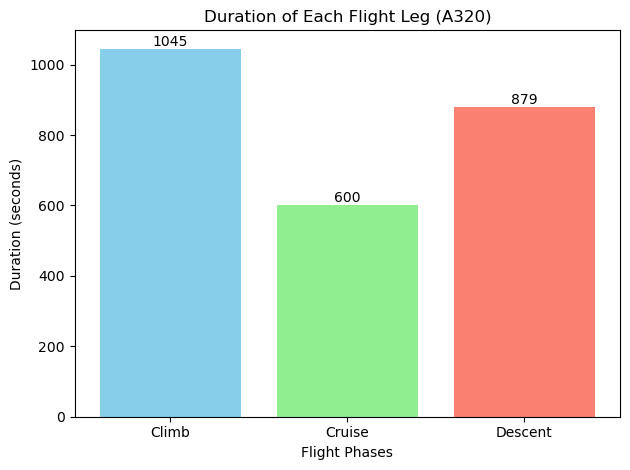

In [13]:
import matplotlib.pyplot as plt
# Sum durations from the flightpath dictionary for each phase
climb_time = (flightpath['climb'].get('t_climb_0_5', 0) +
              flightpath['climb'].get('t_climb_5_10', 0) +
              flightpath['climb'].get('t_climb_10_15', 0) +
              flightpath['climb'].get('t_climb_15_24', 0) +
              flightpath['climb'].get('t_climb_ceil', 0))

descent_time = (flightpath['descent'].get('t_descent_5_0', 0) +
                flightpath['descent'].get('t_descent_10_5', 0) +
                flightpath['descent'].get('t_descent_15_10', 0) +
                flightpath['descent'].get('t_descent_24_15', 0) +
                flightpath['descent'].get('t_descent_ceil', 0))

cruise_time = flightpath['cruise'].get('t_cruise', 0)

# Prepare data for the barchart
phases = ['Climb', 'Cruise', 'Descent']
durations = [climb_time, cruise_time, descent_time]

# Optionally convert seconds to minutes (or leave in seconds)
# durations = [t / 60.0 for t in durations]

plt.figure()
bars = plt.bar(phases, durations, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Flight Phases')
plt.ylabel('Duration (seconds)')
plt.title(f'Duration of Each Flight Leg ({aircraft_typecode})')

# Annotate bars with duration values
for bar, duration in zip(bars, durations):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{duration:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


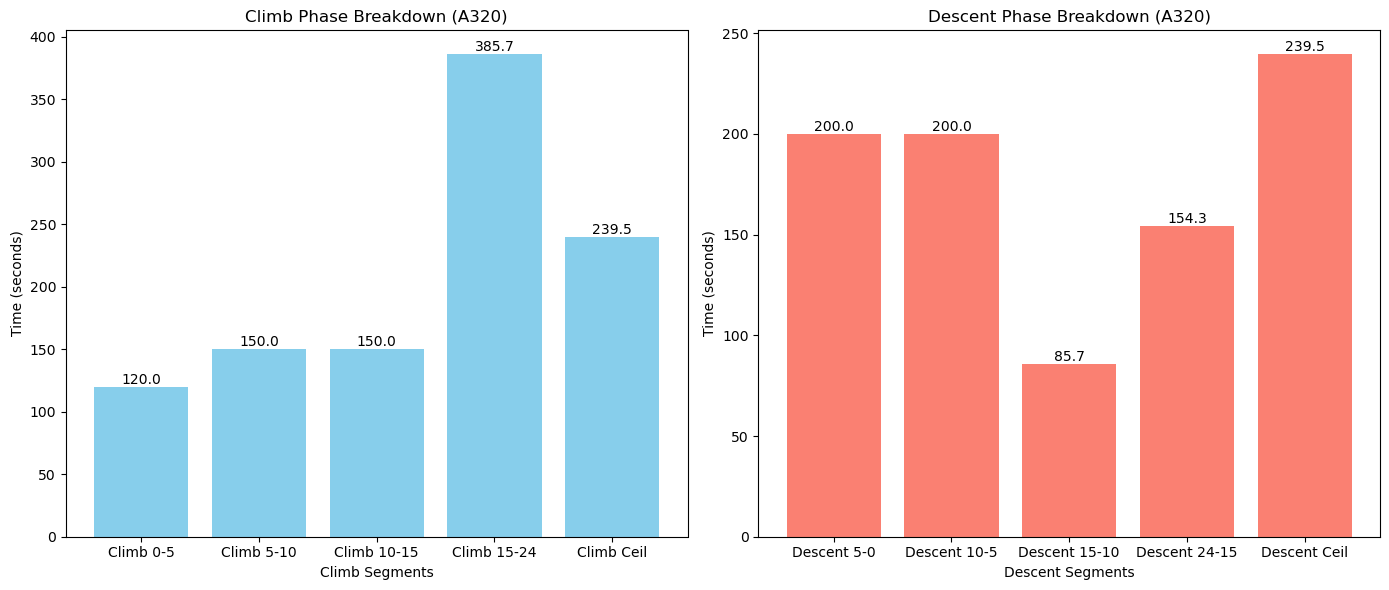

In [14]:
# Break down the climb phases
climb_labels = ['Climb 0-5', 'Climb 5-10', 'Climb 10-15', 'Climb 15-24', 'Climb Ceil']
climb_times = [
    flightpath['climb'].get('t_climb_0_5', 0),
    flightpath['climb'].get('t_climb_5_10', 0),
    flightpath['climb'].get('t_climb_10_15', 0),
    flightpath['climb'].get('t_climb_15_24', 0),
    flightpath['climb'].get('t_climb_ceil', 0)
]

# Break down the descent phases
descent_labels = ['Descent 5-0', 'Descent 10-5', 'Descent 15-10', 'Descent 24-15', 'Descent Ceil']
descent_times = [
    flightpath['descent'].get('t_descent_5_0', 0),
    flightpath['descent'].get('t_descent_10_5', 0),
    flightpath['descent'].get('t_descent_15_10', 0),
    flightpath['descent'].get('t_descent_24_15', 0),
    flightpath['descent'].get('t_descent_ceil', 0)
]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Climb segments chart
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_labels, climb_times, color='skyblue')
plt.xlabel('Climb Segments')
plt.ylabel('Time (seconds)')
plt.title(f'Climb Phase Breakdown ({aircraft_typecode})')
for bar, t in zip(bars_climb, climb_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.1f}', ha='center', va='bottom')

# Descent segments chart
plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_labels, descent_times, color='salmon')
plt.xlabel('Descent Segments')
plt.ylabel('Time (seconds)')
plt.title(f'Descent Phase Breakdown ({aircraft_typecode})')
for bar, t in zip(bars_descent, descent_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


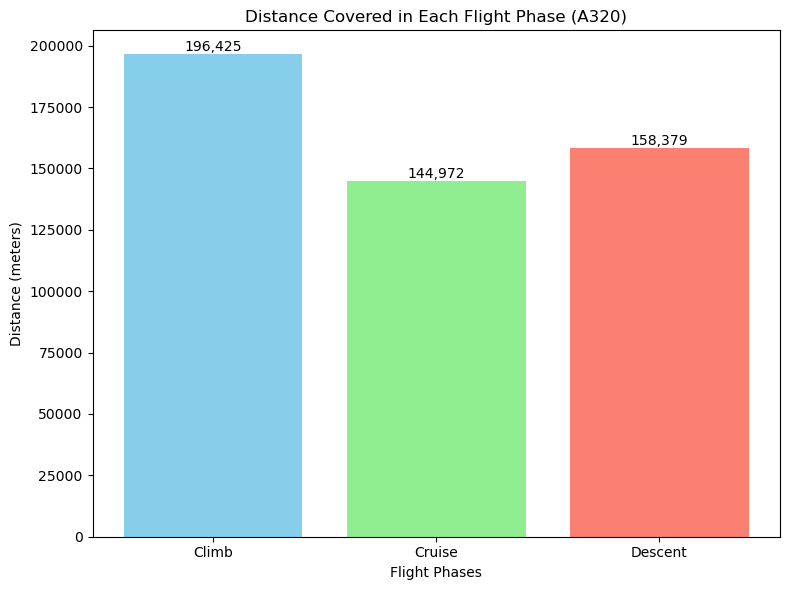

In [15]:
import numpy as np

import matplotlib.pyplot as plt

# Overall phase distances (in meters)
climb_distance = (np.atleast_1d(flightpath['climb'].get('s_climb_0_5', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_5_10', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_10_15', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_15_24', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_ceil', 0))[0])

cruise_distance = np.atleast_1d(flightpath['cruise'].get('s_cruise', 0))[0]

descent_distance = (np.atleast_1d(flightpath['descent'].get('s_descent_5_0', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_10_5', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_15_10', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_24_15', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_ceil', 0))[0])

phases = ['Climb', 'Cruise', 'Descent']
distances = [climb_distance, cruise_distance, descent_distance]

plt.figure(figsize=(8, 6))
overall_bars = plt.bar(phases, distances, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Flight Phases')
plt.ylabel('Distance (meters)')
plt.title(f'Distance Covered in Each Flight Phase ({aircraft_typecode})')

# Annotate overall bars with distance values
for bar, dist in zip(overall_bars, distances):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{dist:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


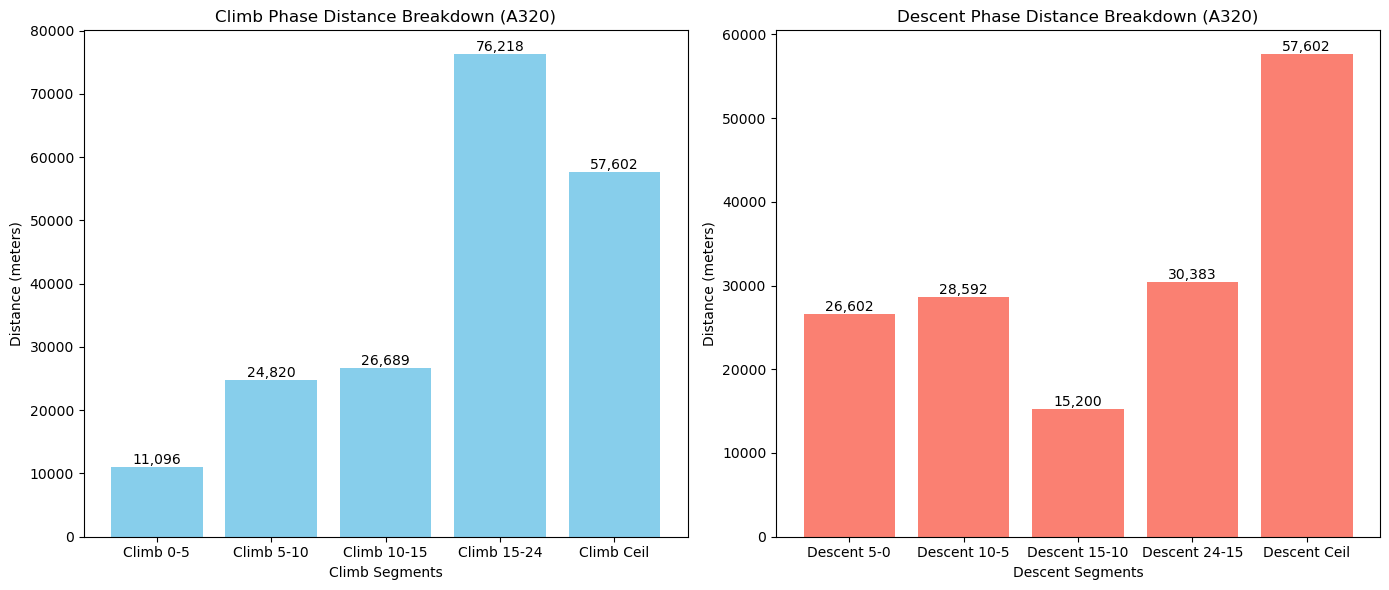

In [16]:


# Breakdown of distances for each segment

# For Climb Phase
climb_keys = ['s_climb_0_5', 's_climb_5_10', 's_climb_10_15', 's_climb_15_24', 's_climb_ceil']
climb_distances = []
for key in climb_keys:
    value = flightpath['climb'].get(key, np.array([0]))
    # value is expected to be a numpy array; extract its first element if so
    if isinstance(value, np.ndarray):
        climb_distances.append(value[0])
    else:
        climb_distances.append(value)

# For Descent Phase
descent_keys = ['s_descent_5_0', 's_descent_10_5', 's_descent_15_10', 's_descent_24_15', 's_descent_ceil']
descent_distances = []
for key in descent_keys:
    value = flightpath['descent'].get(key, np.array([0]))
    if isinstance(value, np.ndarray):
        descent_distances.append(value[0])
    else:
        descent_distances.append(value)

plt.figure(figsize=(14, 6))

# Climb segments chart
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_labels, climb_distances, color='skyblue')
plt.xlabel('Climb Segments')
plt.ylabel('Distance (meters)')
plt.title(f'Climb Phase Distance Breakdown ({aircraft_typecode})')
for bar, d in zip(bars_climb, climb_distances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{d:,.0f}', ha='center', va='bottom')

# Descent segments chart
plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_labels, descent_distances, color='salmon')
plt.xlabel('Descent Segments')
plt.ylabel('Distance (meters)')
plt.title(f'Descent Phase Distance Breakdown ({aircraft_typecode})')
for bar, d in zip(bars_descent, descent_distances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{d:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


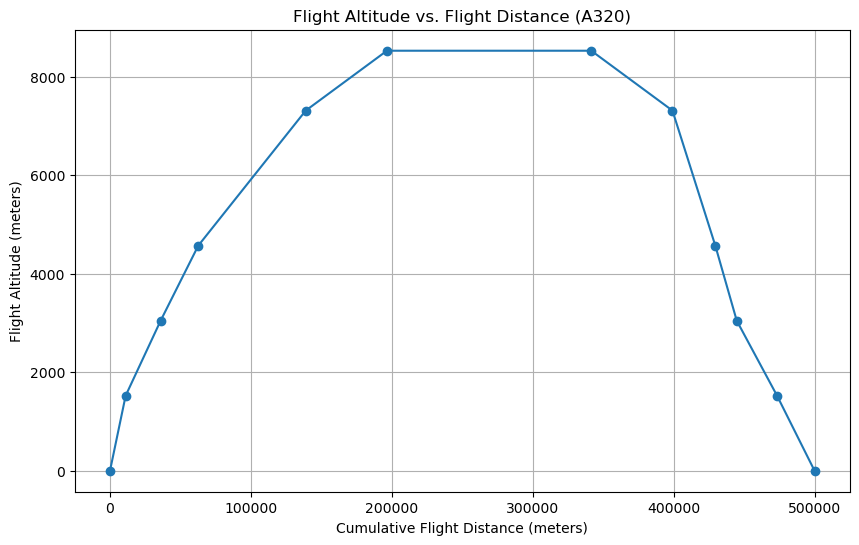

In [17]:
# Build cumulative distance and altitude lists.
# Starting at runway: (distance, altitude) = (0, 0)
distances_list = [0]
altitudes_list = [0]

# Climb phase:
# First climb segment (0-5):
cum_distance = distances_list[-1]
for key in flightpath:
    for key2 in flightpath[key]:
        if key2.startswith('s_'):
            cum_distance += flightpath[key][key2]
            distances_list.append(cum_distance)
            altitudes_list.append(flightpath[key][f'{key2.replace('s_', 'h_')}_end'])

# Plot the altitude profile vs. cumulative flight distance.
plt.figure(figsize=(10, 6))
plt.plot(distances_list, altitudes_list, marker='o', linestyle='-')
plt.xlabel('Cumulative Flight Distance (meters)')
plt.ylabel('Flight Altitude (meters)')
plt.title(f'Flight Altitude vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.show()

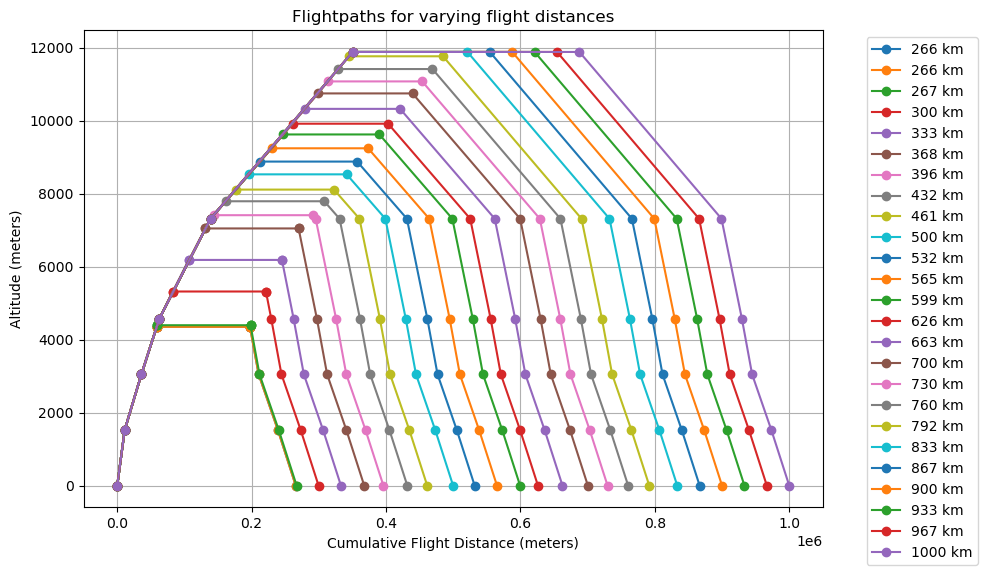

In [18]:
# Generate 25 flight distances (km) linearly spaced from 200 to 5000 km.
num_flightpaths = 25
flight_distances = np.linspace(200, 1000, num_flightpaths)
flightpaths = [0] * num_flightpaths
 
# Loop through each flight distance and generate the flightpath.
for ii in np.arange(num_flightpaths):
    d_km = flight_distances[ii] 
    # Generate flightpath for a given flight distance (in km)
    fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model)
    flightpaths[ii] = fp
plot_flightpaths(flightpaths)

### Visualize NOx Emissions by Flight Phase

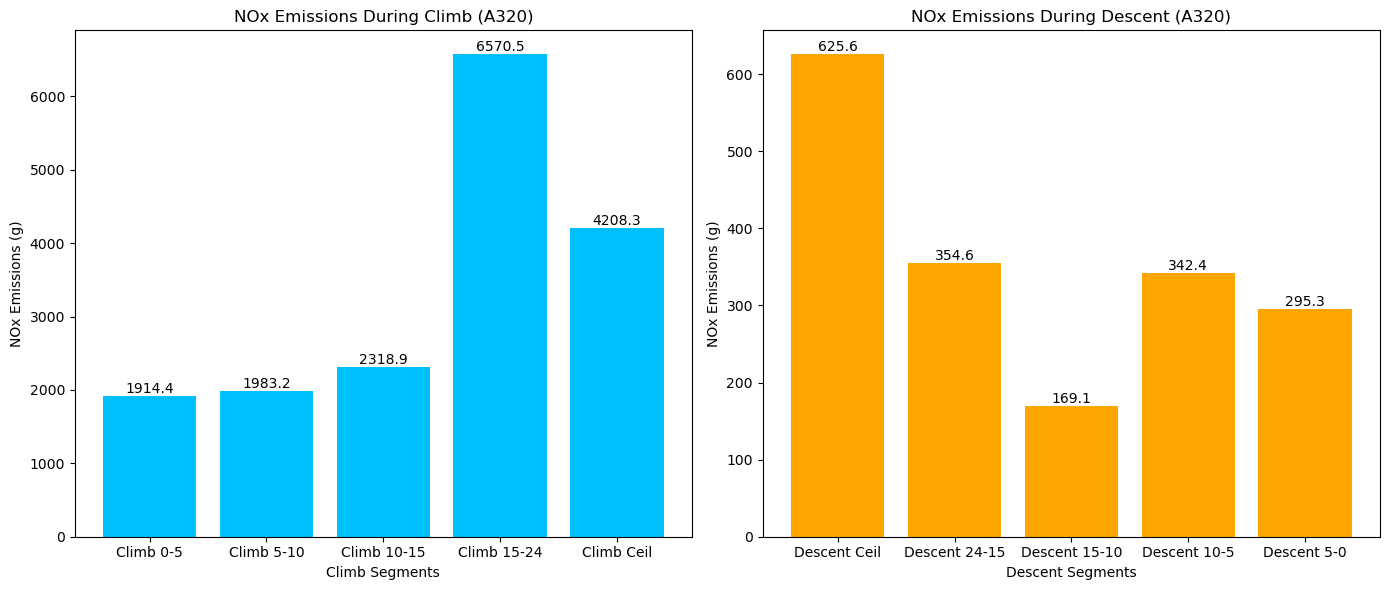

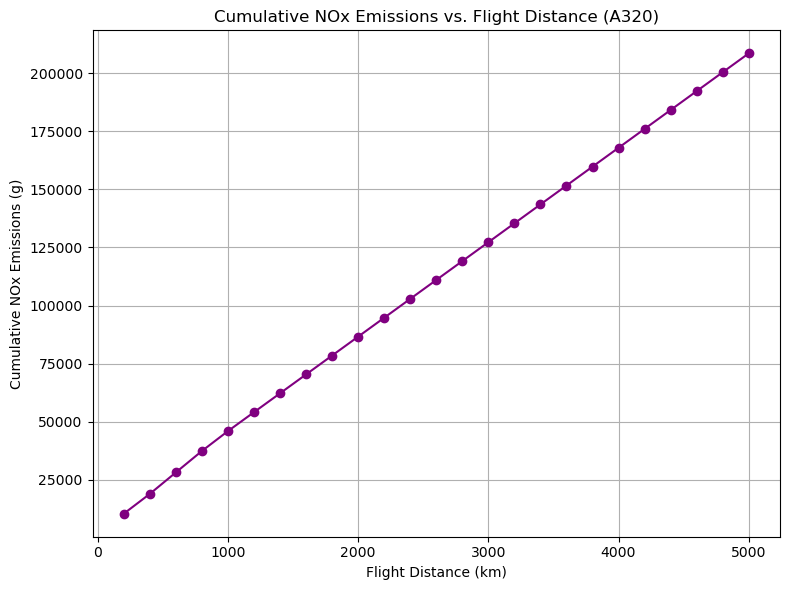

In [19]:
# Visualize NOx emissions for each climb and descent phase
import matplotlib.pyplot as plt

climb_nox_labels = ['Climb 0-5', 'Climb 5-10', 'Climb 10-15', 'Climb 15-24', 'Climb Ceil']
climb_nox_keys = ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']
climb_nox_values = [flightpath['climb'].get(k, 0) for k in climb_nox_keys]

descent_nox_labels = ['Descent Ceil', 'Descent 24-15', 'Descent 15-10', 'Descent 10-5', 'Descent 5-0']
descent_nox_keys = ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']
descent_nox_values = [flightpath['descent'].get(k, 0) for k in descent_nox_keys]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_nox_labels, climb_nox_values, color='deepskyblue')
plt.xlabel('Climb Segments')
plt.ylabel('NOx Emissions (g)')
plt.title(f'NOx Emissions During Climb ({aircraft_typecode})')
for bar, val in zip(bars_climb, climb_nox_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_nox_labels, descent_nox_values, color='orange')
plt.xlabel('Descent Segments')
plt.ylabel('NOx Emissions (g)')
plt.title(f'NOx Emissions During Descent ({aircraft_typecode})')
for bar, val in zip(bars_descent, descent_nox_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Cumulative NOx Emissions vs. Flight Distance
num_flightpaths = 25
flight_distances = np.linspace(200, 5000, num_flightpaths)
cumulative_nox = []
for d_km in flight_distances:
    fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model)
    total_nox = 0
    for k in ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']:
        total_nox += fp['climb'].get(k, 0)
    for k in ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']:
        total_nox += fp['descent'].get(k, 0)
    total_nox += fp.get('cruise', {}).get('NOx_cruise', 0)
    cumulative_nox.append(total_nox)

plt.figure(figsize=(8, 6))
plt.plot(flight_distances, cumulative_nox, marker='o', color='purple')
plt.xlabel('Flight Distance (km)')
plt.ylabel('Cumulative NOx Emissions (g)')
plt.title(f'Cumulative NOx Emissions vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.tight_layout()
plt.show()

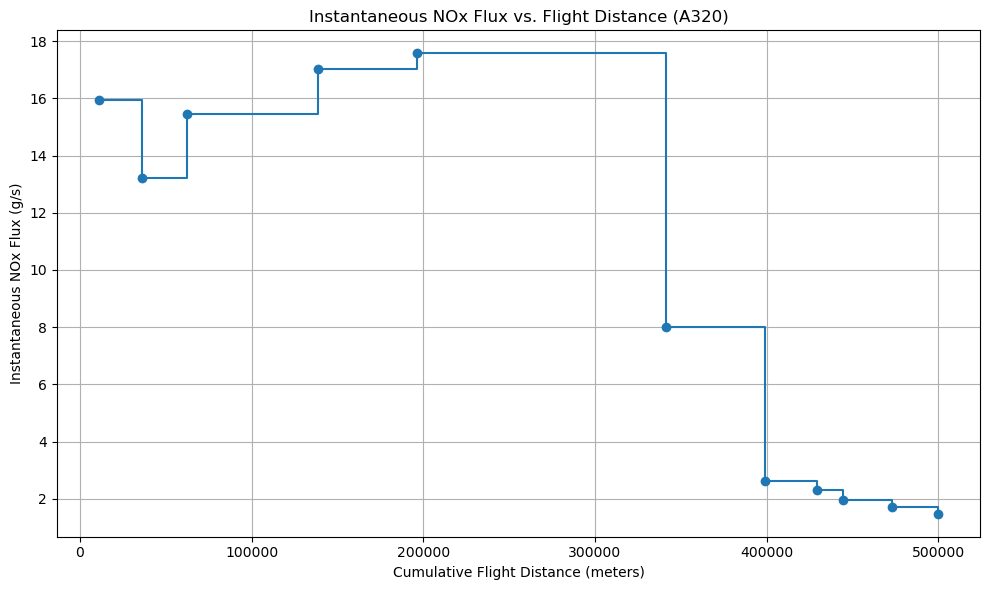

In [20]:
# Instantaneous NOx flux vs. flight distance
import numpy as np
import matplotlib.pyplot as plt

# Build lists for distance and NOx flux (g/s) at each segment
segment_distances = [0]
segment_nox_flux = []

# Climb segments
climb_keys = [
    ('s_climb_0_5', 't_climb_0_5', 'NOx_climb_0_5'),
    ('s_climb_5_10', 't_climb_5_10', 'NOx_climb_5_10'),
    ('s_climb_10_15', 't_climb_10_15', 'NOx_climb_10_15'),
    ('s_climb_15_24', 't_climb_15_24', 'NOx_climb_15_24'),
    ('s_climb_ceil', 't_climb_ceil', 'NOx_climb_ceil'),
]
cum_dist = 0
for s_key, t_key, nox_key in climb_keys:
    s = flightpath['climb'].get(s_key, 0)
    t = flightpath['climb'].get(t_key, 0)
    nox = flightpath['climb'].get(nox_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)

# Cruise segment (if available)
s_cruise = flightpath['cruise'].get('s_cruise', 0)
t_cruise = flightpath['cruise'].get('t_cruise', 0)
nox_cruise = flightpath['cruise'].get('NOx_cruise', 0)
if t_cruise > 0 and s_cruise > 0:
    cum_dist += s_cruise
    segment_distances.append(cum_dist)
    segment_nox_flux.append(nox_cruise / t_cruise if t_cruise > 0 else 0)

# Descent segments
descent_keys = [
    ('s_descent_ceil', 't_descent_ceil', 'NOx_descent_ceil'),
    ('s_descent_24_15', 't_descent_24_15', 'NOx_descent_24_15'),
    ('s_descent_15_10', 't_descent_15_10', 'NOx_descent_15_10'),
    ('s_descent_10_5', 't_descent_10_5', 'NOx_descent_10_5'),
    ('s_descent_5_0', 't_descent_5_0', 'NOx_descent_5_0'),
]
for s_key, t_key, nox_key in descent_keys:
    s = flightpath['descent'].get(s_key, 0)
    t = flightpath['descent'].get(t_key, 0)
    nox = flightpath['descent'].get(nox_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)

# Ensure x and y have the same length by removing the initial 0 from segment_distances.
segment_distances = segment_distances[1:]

plt.figure(figsize=(10, 6))
plt.step(segment_distances, segment_nox_flux, where='post', marker='o')
plt.xlabel('Cumulative Flight Distance (meters)')
plt.ylabel('Instantaneous NOx Flux (g/s)')
plt.title(f'Instantaneous NOx Flux vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.tight_layout()
plt.show()

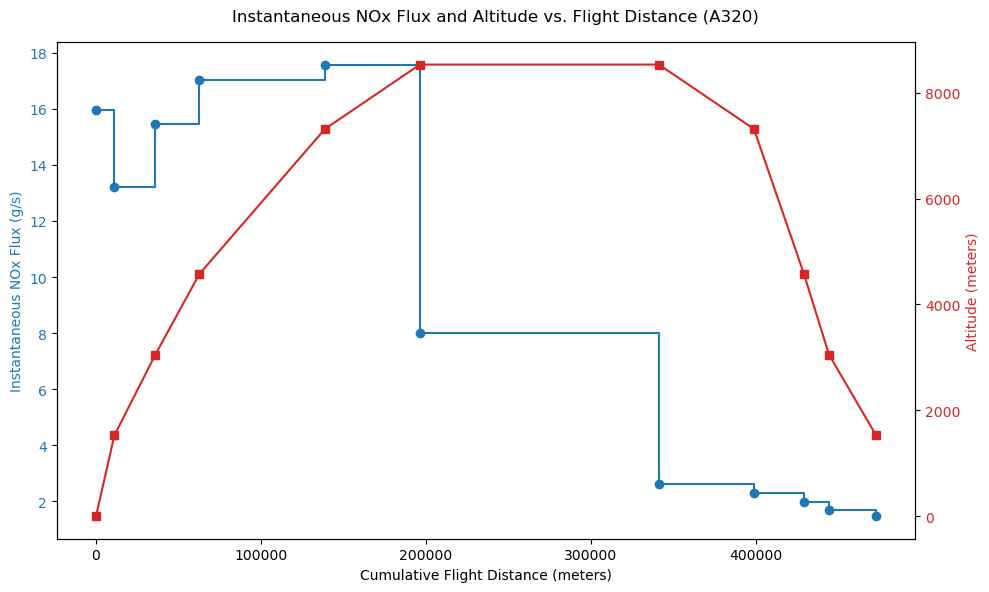

In [ ]:
# Instantaneous NOx flux and altitude vs. flight distance
import numpy as np
import matplotlib.pyplot as plt

# Build lists for distance, NOx flux (g/s), and altitude at each segment
segment_distances = [0]
segment_nox_flux = []
segment_altitudes = [0]

# Climb segments
climb_keys = [
    ('s_climb_0_5', 't_climb_0_5', 'NOx_climb_0_5', 'h_climb_0_5_end'),
    ('s_climb_5_10', 't_climb_5_10', 'NOx_climb_5_10', 'h_climb_5_10_end'),
    ('s_climb_10_15', 't_climb_10_15', 'NOx_climb_10_15', 'h_climb_10_15_end'),
    ('s_climb_15_24', 't_climb_15_24', 'NOx_climb_15_24', 'h_climb_15_24_end'),
    ('s_climb_ceil', 't_climb_ceil', 'NOx_climb_ceil', 'h_climb_ceil_end'),
]
cum_dist = 0
for s_key, t_key, nox_key, h_key in climb_keys:
    s = flightpath['climb'].get(s_key, 0)
    t = flightpath['climb'].get(t_key, 0)
    nox = flightpath['climb'].get(nox_key, 0)
    h = flightpath['climb'].get(h_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)
        segment_altitudes.append(h)

# Cruise segment (if available)
s_cruise = flightpath['cruise'].get('s_cruise', 0)
t_cruise = flightpath['cruise'].get('t_cruise', 0)
nox_cruise = flightpath['cruise'].get('NOx_cruise', 0)
h_cruise = flightpath['cruise'].get('h_cruise_end', 0)
if t_cruise > 0 and s_cruise > 0:
    cum_dist += s_cruise
    segment_distances.append(cum_dist)
    segment_nox_flux.append(nox_cruise / t_cruise if t_cruise > 0 else 0)
    segment_altitudes.append(h_cruise)

# Descent segments
descent_keys = [
    ('s_descent_ceil', 't_descent_ceil', 'NOx_descent_ceil', 'h_descent_ceil_end'),
    ('s_descent_24_15', 't_descent_24_15', 'NOx_descent_24_15', 'h_descent_24_15_end'),
    ('s_descent_15_10', 't_descent_15_10', 'NOx_descent_15_10', 'h_descent_15_10_end'),
    ('s_descent_10_5', 't_descent_10_5', 'NOx_descent_10_5', 'h_descent_10_5_end'),
    ('s_descent_5_0', 't_descent_5_0', 'NOx_descent_5_0', 'h_descent_5_0_end'),
]
for s_key, t_key, nox_key, h_key in descent_keys:
    s = flightpath['descent'].get(s_key, 0)
    t = flightpath['descent'].get(t_key, 0)
    nox = flightpath['descent'].get(nox_key, 0)
    h = flightpath['descent'].get(h_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)
        segment_altitudes.append(h)

# Ensure all arrays have the same length for plotting
min_len = min(len(segment_distances), len(segment_nox_flux), len(segment_altitudes))
segment_distances_plot = segment_distances[:min_len]
segment_nox_flux_plot = segment_nox_flux[:min_len]
segment_altitudes_plot = segment_altitudes[:min_len]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.step(segment_distances_plot, segment_nox_flux_plot, where='post', marker='o', color='tab:blue', label='NOx Flux (g/s)')
ax1.set_xlabel('Cumulative Flight Distance (meters)')
ax1.set_ylabel('Instantaneous NOx Flux (g/s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(segment_distances_plot, segment_altitudes_plot, marker='s', color='tab:red', label='Altitude (m)')
ax2.set_ylabel('Altitude (meters)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle(f'Instantaneous NOx Flux and Altitude vs. Flight Distance ({aircraft_typecode})')
fig.legend()
fig.tight_layout()
plt.show()

TEST CODE

In [22]:
from download_day import download_day
from load_saved_fd4 import load_saved_fd4
from scrape_aircraft_list import scrape_aircraft_list
from get_perf_model_typecodes import get_perf_model_typecodes 
from match_icao_model import match_icao_model
from process_airport_list import process_airport_list
from generate_flightpath import generate_flightpath
from plot_flightpaths import plot_flightpaths
from get_engine_data import get_engine_data
from perf_model_powerplant_parser import perf_model_powerplant_parser
from match_engine_to_emissions_db import match_engine_to_emissions_db
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import sleep
from geopy import distance
from icet import icet
from bffm2 import bffm2
from ft_to_m import ft_to_m
%matplotlib inline

In [23]:
aircraft_data = pd.read_pickle('performance_and_emissions_model.pkl')

altitude = ft_to_m(2500) # Convert altitude from feet to meters
mach = 0.84 # Mach number
W_f = aircraft_data.iloc[0]['Fuel Flow T/O (kg/sec)'] * 7936.64 # kg/s to lbs/hr

tester = aircraft_data[aircraft_data['typecode'] == 'A320']

HC_ei_0_5, CO_ei_0_5, NOx_ei_0_5 = bffm2(tester, altitude, mach, W_f)
print("HC_ei_0_5: " + str(HC_ei_0_5))
print("CO_ei_0_5: " + str(CO_ei_0_5))
print("NOx_ei_0_5: " + str(NOx_ei_0_5))

HC_ei_0_5: [0.23836744]
CO_ei_0_5: [0.9946981]
NOx_ei_0_5: [7.21929062]
